# AnaStruct Introductory Project Outline

Hellooo everyone, my name is Irenaeus and I will be guiding you through your very first Computational Materials project! We will be using the open source AnaStruct python library to develop a reusable module to generate 2D cellular hexagonal structures and test them with classic beam elemental analysis (The same calculations you learn in ENG 2P04). 

This project is more of an exercise, and its purpose includes the following:

- Using open source python libraries
- Rapid prototyping of code using Jupyter
- Basic code organization and data structures
- Basic Finite Element Analysis (FEA)
- Introduction to generative algorithms (very intro...dw)
- Problem definition and break-down

Ultimately, the aim of this introductory project is to demonstrate how to break down a complex problem into 'milestones', and then further break down those milestones into individual steps that could be 'googled'.

# Problem Objectives:

### User Inputs:
- Number of Hexagons in x-direction -> type=int
- Number of Hexagons in y-direction -> type=int
- Force applied to top members [N] -> type=float
- Elastic Modulus of Material [Pa] -> type=float
- List of locations of reinforcements -> type=list of length **n-1** -> [ ($x_{0}$, $y_{0}$), ($x_{1}$, $y_{1}$), ... , ($x_{n-1}$, $y_{n-1}$) ]
- Lattice Parameter [m] -> type=float

### Output:
The program will draw the hexagon lattice as described by the user input parameters, and produce the following:
- Structure Diagram
- Shear Force Diagram
- Reaction Force Diagram
- Displacement Diagram
- Bending Moment Diagram 
- Axial Force Diagram

## Example I/O

### Input:
- Number of Hexagons in x-direction = 5
- Number of Hexagons in y-direction = 5
- Force applied to top members = -1000
- Elastic Modulus of Material [Pa] = **17x**$10^{9}$
- List of locations of reinforcements = [(0,0), (1,1), (2,2), (3, 3), (4, 4)]
- Lattice Parameter = 1

##### Shown below is the sample code I have written to show user input (can ignore all parameters not mentioned above as I used those for my research)

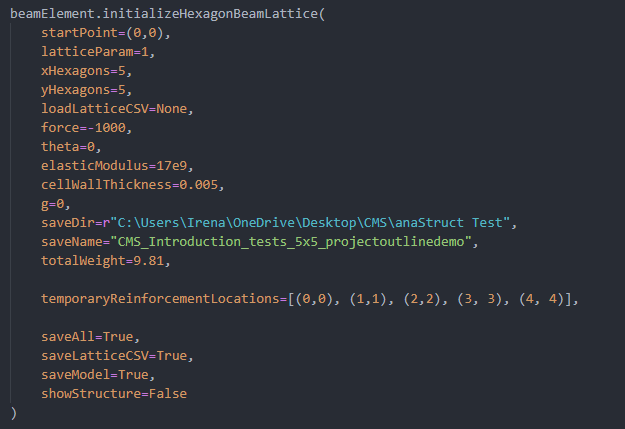

### Output:

##### Shown below is the Structure Diagram:

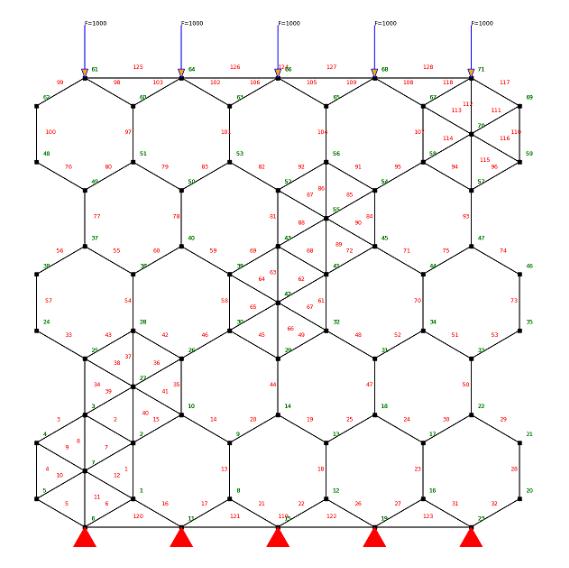

##### Shown below is the directory where the outputs have been saved:
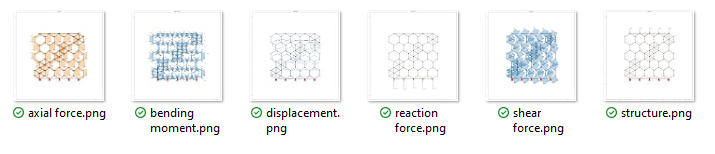

## Vibe Check
Although it would be cool to have everyone work hard to produce a code that can accomplish the above, it would take more time and would defeat the ultimate purpose of a quick introduction to open source programming in Python...

## Real Final Expectation
- Accomplish all of the above, except you can leave the parameter **Number of Hexagons in y-direction -> type=int** to always be equal to 1.
    --> Meaning we are only going to model one row of hexagons instead of a 2D lattice
    (trust me, there's a lot more nuance to extending it to 2D than you might think...it has a lot to do with how the original developer wrote AnaStruct...I'm not a big fan) 
    
# Constraints
### As you may have noticed, there are a few details to understand before accomplishing this task. 
- Supports must be placed as shown in the example output above -> on lowest nodes
- Lowest nodes must be connected by beam members, as shown in the example output above
- Forces must be placed as shown in the example output above -> on highest nodes
- Highest nodes must be connected by beam members, as shown in the example output above
- Hexagons are to be stacked in the 'zig-zag' orientation 
    -> Described as shown: https://www.researchgate.net/figure/color-online-Hexagons-in-a-armchair-and-b-zigzag-orientations-Semi-infinite-input_fig1_225166468
    
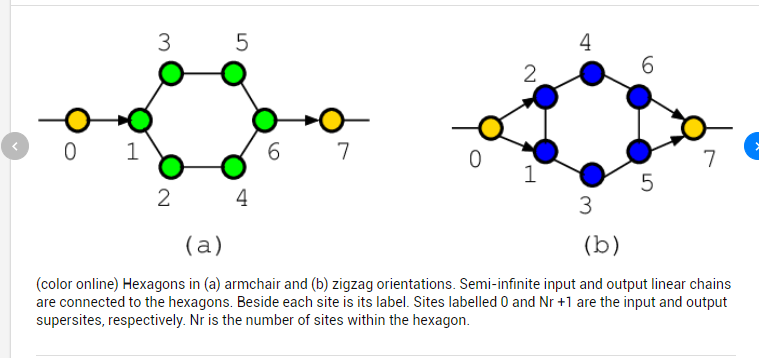

# Now the Fun Part, What Now?

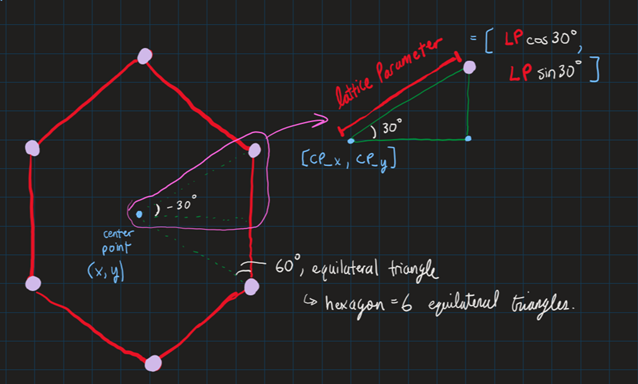

In [ ]:
# Code to generate hexagon points, when given a center point 

def hexagonPoints(center, size, roundDecimals=10, invertHex=True): 
    '''
    This function  generates points to throw to anastruct system elements 
    to draw 2D honeycomb stuctures. 

    Args: 
        (center):
            (tuple): Center coordinates of hexagon to be drawn. 


    Hexagon Points Indexing graphic: 


                   .1
                 -    -
              -          -  0
             -2            -
            .               .
            .               .
            .               . 
            .3              .5
             -             -
                 -      -
                    .4

    '''

    points = [] 

    for i in range(6): 

        # Start angel at 0 and increment by 60 each time 
        if invertHex == False: 
            current_angle = 60*(i+1) 
        else: 
            # Start angle at 30 and increment by 60 each time 
            current_angle = 30 + 60*(i) 
        angle_radians = (np.pi/180)*current_angle 

        curr_x = center[0] + size*np.cos(angle_radians) 
        curr_y =  center[1] + size*np.sin(angle_radians) 

        curr_x = np.round(curr_x, roundDecimals) 
        curr_y = np.round(curr_y, roundDecimals) 

        if curr_x == -0.0: 
            curr_x = 0.0 
        if curr_y == -0.0: 
            curr_y = 0.0 

        points.append( ( curr_x, curr_y ) ) 

    return points 

In [ ]:
# Other useful functions I wrote that might be useful to you if you want 
# to explore this library!
def checkSystemElement(point1, point2, pointPairList): 
    '''
    This function searches through a point list to see if a pair 
    of points is present already in the pointsList. To be used so that
    an anaStruct object of class SystemElements() does not repeat an element. 
    This fucks up the total FE simultion. 

    Args:

        (point1): 
            (tuple): First point in the element. 
        (point2):
            (tuple): Second point in the element. 
        (pointPairList): 
            (list): List of points to be searched. 

    Returns: 
        (return1): 
            (boool): Whether or not the point pair has been found 

        (return2): 
            (int/None): If the point pair is found within the pointList, the index
            at which the point pair is found will be returned. Otherwise if the point pair
            is not found, a None type will be returned. 
    '''
    try: 
        index = pointPairList.index( (point1, point2) )
    except ValueError: 
        
        # If not found, try different orientation of points 
        try: 
            index = pointPairList.index( (point2, point1) ) 
        except ValueError: 

            # Pair of points consisting of point1 and point2 do not
            # exist in the given pointPairList[]. 
            return False, None  
    
    # if it doesn't return false in the above code, return the index
    return True, index 


In [ ]:
# Code for finding the highest and lowest nodes, and returning their node ID's
# so that we can add supports or forces on them. 
def findLowestNodes(ss, startPoint, latticeParam, xHexagons, yHexagons): 
    '''
    Gets lowest node points of the given 2D hexagon crystal lattice. 
    Returns node id's and (x,y) locations for further processing. 

    Args: 

        (ss): 
            (SystemElements): System elements type object. 
        (startPoint): 
            (tuple): (x,y) coordinates of crystal lattice start point. 
        (latticeParam): 
            (int/float): Lattice parameter of hexagons to be drawn. 
        (xHexagons): 
            (int): Number of hexagons in x-direction of lattice. 
        (yHexagons): 
            (int): Number of hexagons in y-direction of lattice. 
    
    Returns: 

        (return1): 
            (list[int, tuple]): List containing node ID of SystemElements object as well as 
            the (x,y) coordinates of each node found. 

    '''

    nodes = [] 
    
    hex_x_distance = 2*latticeParam*np.cos(np.pi/6)
    hex_y_distance = latticeParam + latticeParam*np.sin(np.pi/6)

    curr_x = startPoint[0] 
    curr_y = startPoint[1] - latticeParam 

    for i in range(xHexagons): 

        curr_node_location = ( np.round(curr_x,2), np.round(curr_y,2) ) 
        curr_node_id = ss.find_node_id( curr_node_location )

        try: 
            assert curr_node_id != None
        except AssertionError: 
            print("Assertion Error: No node corresponding to (x,y)={} was found.".format(curr_node_location))
            return None 

        nodes.append( (curr_node_id, curr_node_location) ) 

        curr_x += np.round(hex_x_distance, 2) 

    return nodes  
        
def findHighestNodes(ss, startPoint, latticeParam, xHexagons, yHexagons): 
    '''
    Gets highest node points of the given 2D hexagon crystal lattice. 
    Returns node id's and (x,y) locations for further processing. 

    Node location calculation/iteration is dependent on the number of hexagon
    lattice rows are present. If the number of rows are an odd number, an
    offset of 0.5*hex_x_distance needs to be incremented to the node search
    algorithm to account for the alternating hexagon structure. 

    Args: 

        (ss): 
            (SystemElements): System elements type object. 
        (startPoint): 
            (tuple): (x,y) coordinates of crystal lattice start point. 
        (latticeParam): 
            (int/float): Lattice parameter of hexagons to be drawn. 
        (xHexagons): 
            (int): Number of hexagons in x-direction of lattice. 
        (yHexagons): 
            (int): Number of hexagons in y-direction of lattice. 
    
    Returns: 

        (return1): 
            (list[int, tuple]): List containing node ID of SystemElements object as well as 
            the (x,y) coordinates of each node found. 

    '''

    nodes = [] 

    hex_x_distance = 2*latticeParam*np.cos(np.pi/6)
    hex_y_distance = latticeParam + latticeParam*np.sin(np.pi/6)

    # Start x depending on the number of rows of the lattice
    if yHexagons%2 != 0: 
        curr_x = startPoint[0] 
        nodeCount = xHexagons 
    else: 
        curr_x = startPoint[0] - 0.5*hex_x_distance 
        nodeCount = xHexagons + 1 

    
    # Start y parameter based on number of rows 
    curr_y = startPoint[1] + hex_y_distance*(yHexagons-1) + latticeParam 

    for i in range(nodeCount): 

        curr_node_location = (np.round(curr_x,2), np.round(curr_y,2)) 
        curr_node_id = ss.find_node_id( curr_node_location )

        try: 
            assert curr_node_id != None 
        except AssertionError: 
            print("Assertion Error: No node corresponding to (x,y)={} was found.".format(curr_node_location))

        nodes.append( (curr_node_id, curr_node_location) ) 

        curr_x += np.round(hex_x_distance, 2) 

    return nodes 